In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
length = 10000
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0 #(average of zero)
lst_dct = {col:[] for col in cols}
sigma = 5  #(standard deviation of 5)

In [2]:
lst_dct = {col:[] for col in cols}
for i in range(length):
    lst_dct["P"].append(25 + np.random.normal(mu, .5 * sigma))
    lst_dct["Q"].append(50 + np.random.normal(mu, sigma))
    lst_dct["X"].append(3 * lst_dct["Q"][-1]  + np.random.normal(mu, sigma ))
    lst_dct["Y"].append(lst_dct["Q"][-1] * -1 +  np.random.normal(mu, sigma))
    lst_dct["Z"].append(lst_dct["P"][-1] * 2 +  1.5 * lst_dct["X"][-1] -  lst_dct["Y"][-1] * 2 +  np.random.normal(mu,  sigma))
df = pd.DataFrame(lst_dct)
keys = cols 
df

,P,Q,X,Y,Z
0,30.262582,55.071096,167.208392,-53.370587,427.960883
1,28.011727,50.755584,158.562493,-57.115153,412.260482
2,26.485033,58.134850,179.423694,-58.380224,435.171766
3,23.290459,50.500932,150.136371,-53.946926,379.417921
4,26.530887,53.295691,153.008682,-58.623049,400.436826
...,...,...,...,...,...
9995,22.550107,54.427981,172.400831,-54.112959,404.278098
9996,27.471831,46.787546,144.944700,-43.542426,361.606978
9997,26.218185,50.986908,151.023104,-48.472654,380.271964
9998,30.231798,47.747121,138.252771,-51.831203,360.520388


<AxesSubplot:xlabel='Q', ylabel='Z'>

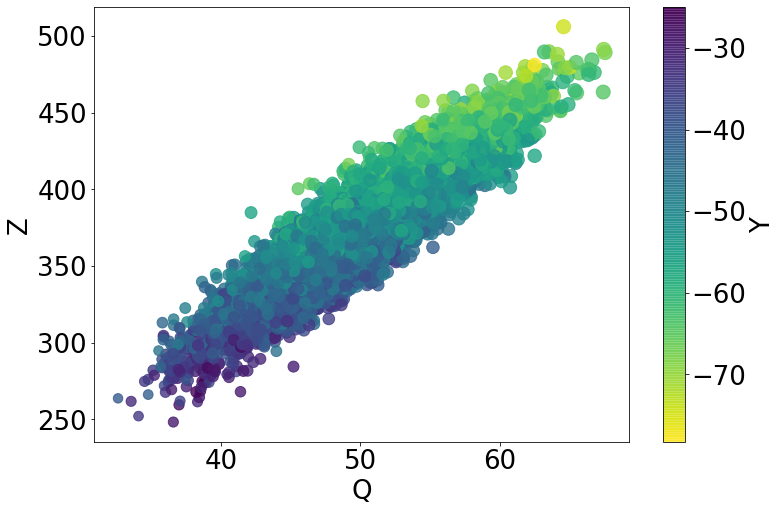

In [3]:
plt.rcParams.update({"font.size":26})
fig, ax = plt.subplots(figsize = (12,8))
df.plot.scatter(x = "Q", y = "Z", c = "Y",s = "X", cmap = "viridis_r",alpha = .8, ax = ax)

In [4]:
df.corr()

,P,Q,X,Y,Z
P,1.000000,-0.011049,-0.016019,0.023228,0.121083
Q,-0.011049,1.000000,0.949359,-0.703349,0.916580
X,-0.016019,0.949359,1.000000,-0.670398,0.935686
Y,0.023228,-0.703349,-0.670398,1.000000,-0.843544
Z,0.121083,0.916580,0.935686,-0.843544,1.000000


In [5]:
import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)

In [6]:
residuals

,P,Q,X,Y,Z
0,0.166177,-0.071478,-3.898429,4.248905,9.813299
1,0.460749,-2.262405,-0.082537,0.484601,4.383072
2,1.715785,-0.634996,3.278381,-1.560639,-3.703844
3,-0.773800,0.162461,-0.371960,-0.775998,-0.244634
4,0.642345,1.719443,-2.419388,-0.895374,0.508688
...,...,...,...,...,...
9995,0.724435,-1.965486,6.297862,-2.940109,-7.528972
9996,0.662322,-1.293471,0.408404,1.548494,2.234529
9997,-0.479795,0.805664,-2.584972,2.201514,4.248950
9998,5.360884,0.867935,3.564429,-5.306188,-11.002327


In [7]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,P,Q,X,Y,Z
P,1.00,-0.01,-0.59,0.64,0.71
Q,-0.01,1.00,0.48,-0.10,0.03
X,-0.59,0.48,1.00,0.74,0.83
Y,0.64,-0.10,0.74,1.00,-0.89
Z,0.71,0.03,0.83,-0.89,1.00


In [8]:
import pingouin
df.corr().round(2)

,P,Q,X,Y,Z
P,1.00,-0.01,-0.02,0.02,0.12
Q,-0.01,1.00,0.95,-0.70,0.92
X,-0.02,0.95,1.00,-0.67,0.94
Y,0.02,-0.70,-0.67,1.00,-0.84
Z,0.12,0.92,0.94,-0.84,1.00


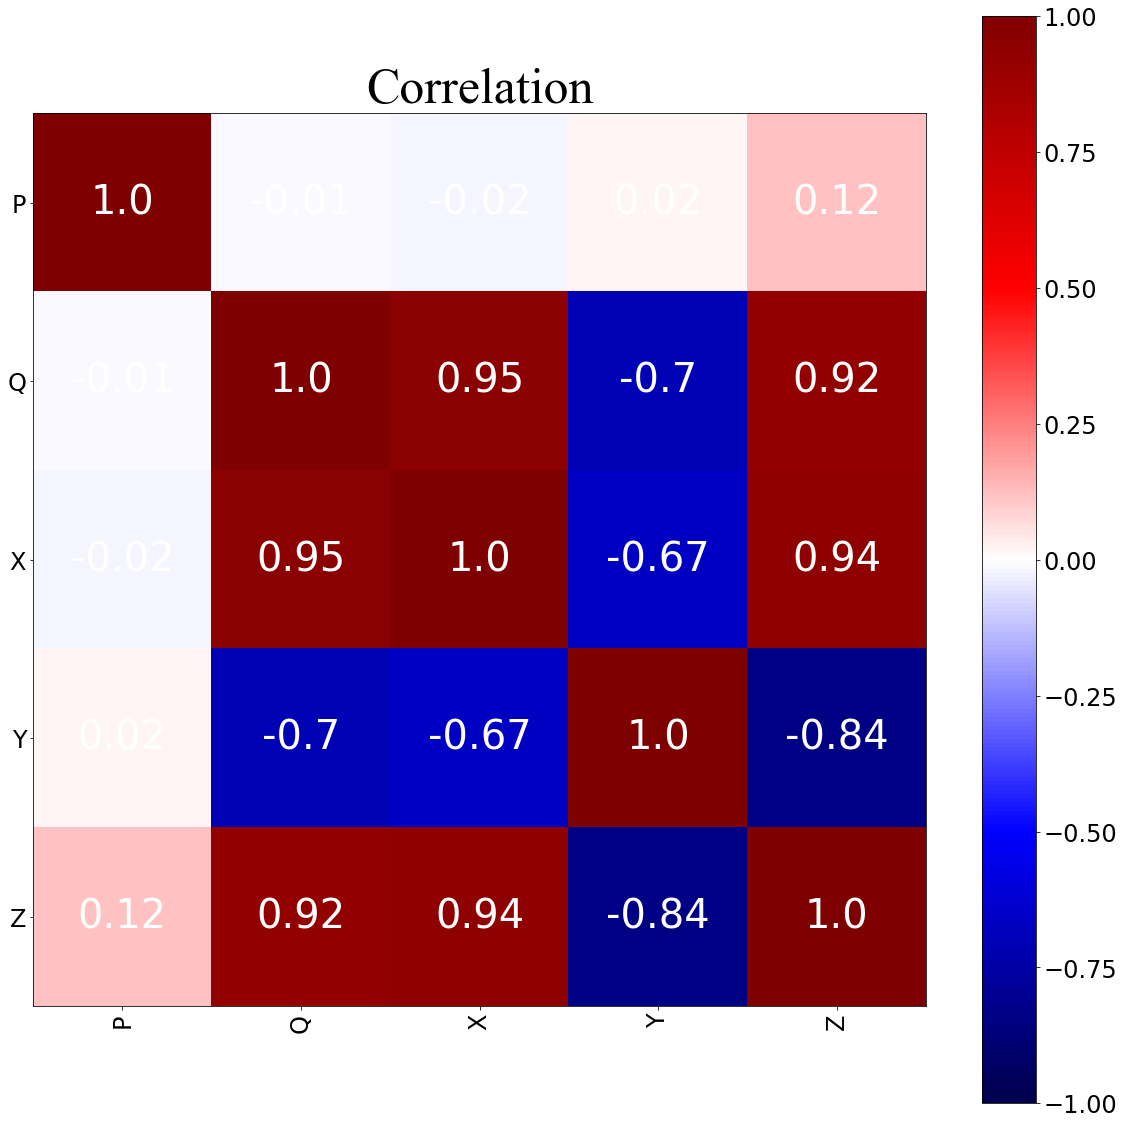

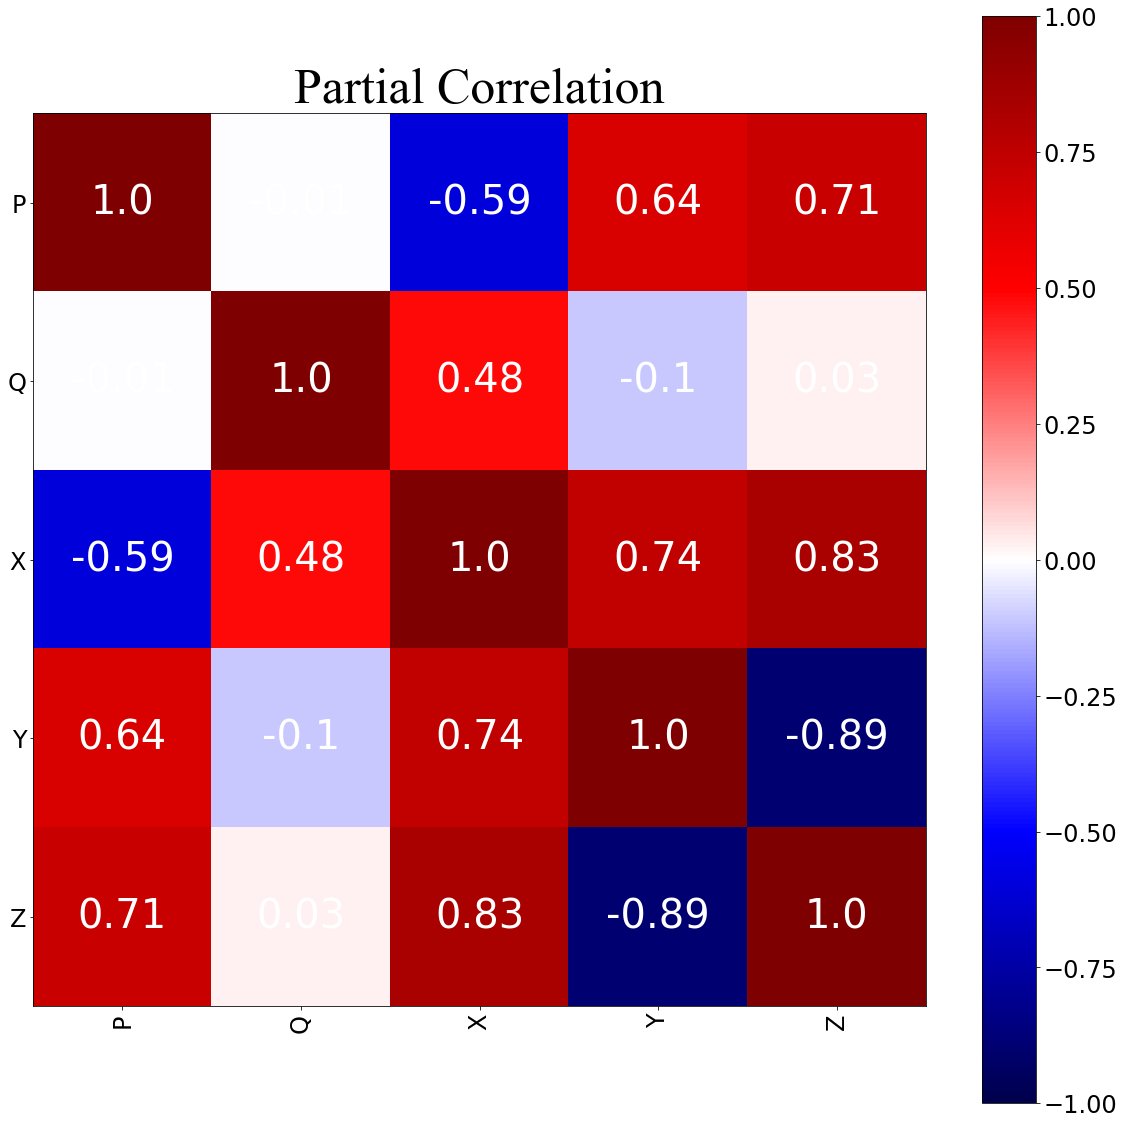

In [9]:
from datlib.plots import *
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None, 
                    title = "Correlation")

corr_matrix_heatmap(df.pcorr(), 
                    save_fig = False, 
                    pp = None, 
                    title = "Partial Correlation")

In [10]:
pcorr_pvalues = {}

for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            # this will regress one residual on the other, save the pvalue for the explanatory variable
            # and create a pvalue partial correlation
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

,P,Q,X,Y,Z
P,NaN,0.49,0.0,0.0,0.0
Q,0.49,NaN,0.0,0.0,0.0
X,0.00,0.00,NaN,0.0,0.0
Y,0.00,0.00,0.0,NaN,0.0
Z,0.00,0.00,0.0,0.0,NaN


In [16]:
undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    undirected_graph[x] = [y for y in df.keys() if y != x]
undirected_graph

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

In [17]:
import copy
p_val = 0.01
def build_skeleton(df, undirected_graph):
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                # recursive function that iterates through remaining variables 
                #  uses them as controls statistical significance holds without them,
                #  otherwise break
                #print(sorted(list(set(c_used))))
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)

    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x !=y:
                test = df.partial_corr(x=x,
                                      y=y,
                                      covar=None,
                                      method="pearson")
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
                else:
                    control_vars = [z for z in df.keys() if z !=y and z !=x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

print(build_skeleton(df, undirected_graph))

{'P': ['Z'], 'Q': ['X', 'Y', 'Z'], 'X': ['Q', 'Z'], 'Y': ['Q', 'Z'], 'Z': ['P', 'Q', 'X', 'Y']}


In [13]:
import matplotlib.pyplot as plt
import networkx as nx

def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))
    print(edges)
    print(edge_labels)
    
    graph.add_edges_

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

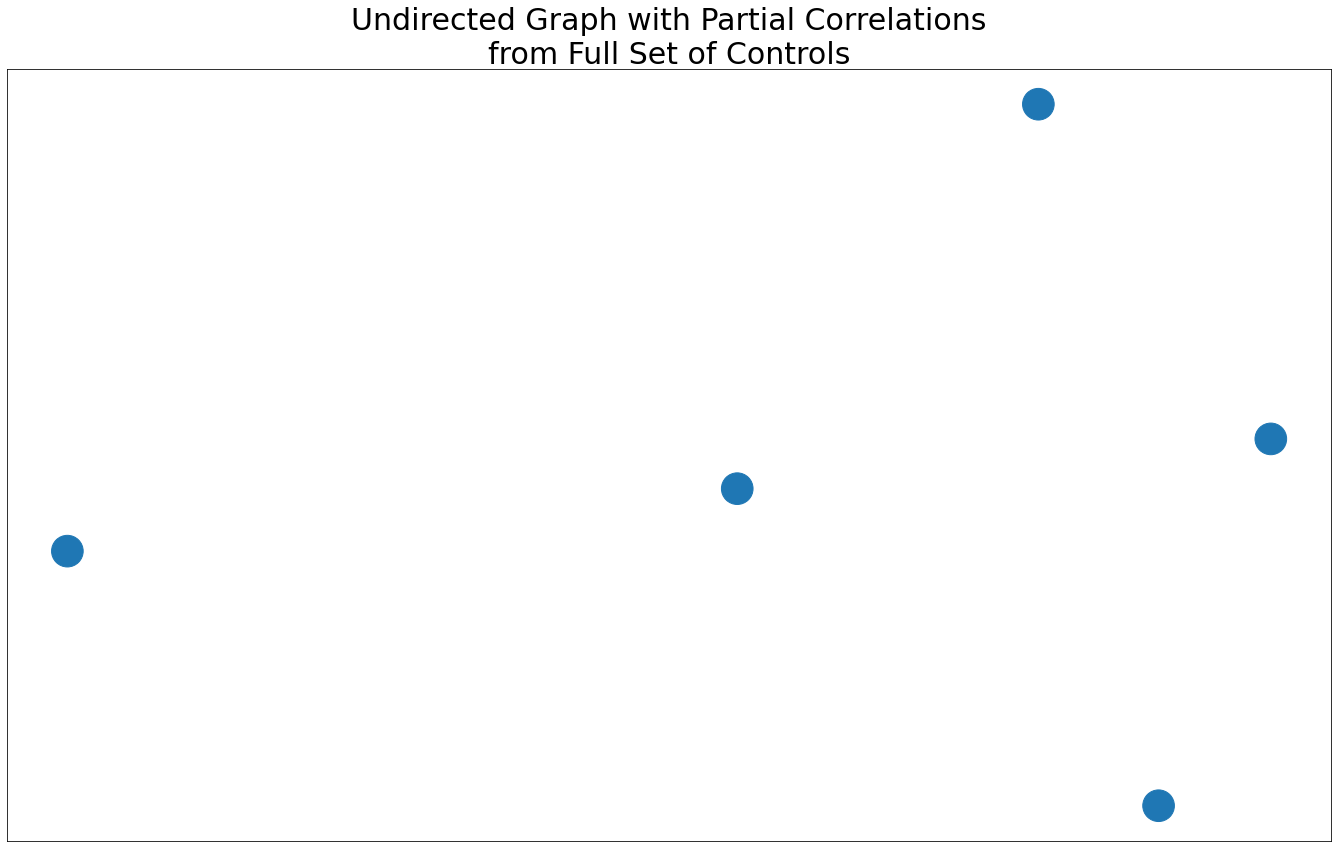

In [14]:
graph_DAG(undirected_graph, df, title = "Undirected Graph with Partial Correlations\nfrom Full Set of Controls")